In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import tensorflow_probability
tfp = tensorflow_probability.experimental.substrates.jax
tfk = tfp.math.psd_kernels
import haiku as hk
from jax.experimental import optix
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import sys; sys.path.insert(0, '..')
from sparsegpax import SparseGaussianProcess
from sparsegpax.kernel import ScaledKernel

In [2]:
rng = hk.PRNGSequence(1)
initial_state = hk.transform(lambda: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).get_initial_state())
model = hk.transform(lambda x,s: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17)(x,s))
prior = hk.transform(lambda x,s: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).prior(x,s))
randomize = hk.transform(lambda s: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).randomize(s))
resample_prior_basis = hk.transform(lambda s: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).resample_prior_basis(s))
prior_kl = hk.transform(lambda s: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).prior_KL(s))
err_stddev = hk.transform(lambda: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).err_stddev())
hyperprior = hk.transform(lambda: SparseGaussianProcess(ScaledKernel(tfk.ExponentiatedQuadratic,1,1), 1, 1, 11, 67, 17).hyperprior())

In [3]:
@jax.jit
def loss(params,key,x,y,n_data,gpstate):
    gpstate = randomize.apply(params,key,gpstate)
    #
    kl = prior_kl.apply(params,jr.PRNGKey(0),gpstate)
    #
    f = model.apply(params,jr.PRNGKey(0),x,gpstate)
    s = err_stddev.apply(params,jr.PRNGKey(0))
    (n_samples,_,n_batch) = f.shape
    c = n_data / (n_batch * n_samples * 2)
    l = n_data*jnp.sum(jnp.log(s)) + c*jnp.sum(((y - f) / s)**2)
    #
    r = hyperprior.apply(params,jr.PRNGKey(0))
    #
    return kl + l + r

def plot(x,y,f):
    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)
    #
    (fig,ax) = plt.subplots()
    ax.scatter(x,y)
    ax.plot(x,m,linewidth=2)
    ax.fill_between(x, l, u, alpha=0.5)
    #
    for i in range(f.shape[0]):
        ax.plot(x,f[i,:], color="gray",alpha=0.5)
    #
    fig.show()

In [4]:
x = jnp.expand_dims(jnp.linspace(-5,5,101), -1)
y = 2 * jnp.sin(x).T + jr.normal(next(rng), x.T.shape)/10

In [5]:
params = initial_state.init(next(rng))
gpstate = initial_state.apply(params, next(rng))

In [6]:
params = hk.data_structures.merge(params,{
    'sparse_gaussian_process': {
        'inducing_locations': jnp.expand_dims(jnp.linspace(-5,5,11), -1),
        }
    })
gpstate = resample_prior_basis.apply(params,next(rng),gpstate)
gpstate = randomize.apply(params,next(rng),gpstate)

In [7]:
loss(params,next(rng),x,y,x.shape[0],gpstate)

DeviceArray(118.939896, dtype=float32)

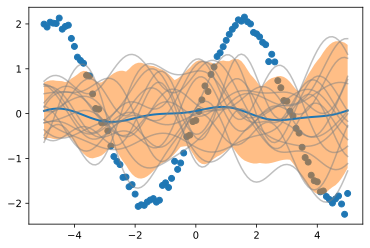

In [8]:
gpstate = randomize.apply(params,next(rng),gpstate)
plot(x[:,0],y[0,:],model.apply(params,jr.PRNGKey(0),x,gpstate)[:,0,:])

In [9]:
opt = optix.adam(0.01)
opt_state = opt.init(params)

In [10]:
for i in range(200):
    (train_loss,grads) = jax.value_and_grad(loss)(params,next(rng),x,y,x.shape[0],gpstate)
    (updates,opt_state) = opt.update(grads, opt_state)
    params = optix.apply_updates(params,updates)
    if i <= 10 or i % 20 == 0: print(i,"Loss:",train_loss)

0 Loss: 127.95373
1 Loss: 130.84587
2 Loss: 118.79238
3 Loss: 97.65466
4 Loss: 111.22823
5 Loss: 113.44128
6 Loss: 97.95519
7 Loss: 106.17797
8 Loss: 103.50353
9 Loss: 106.30159
10 Loss: 99.35865
20 Loss: 86.90827
40 Loss: 56.3072
60 Loss: 34.317955
80 Loss: 14.5158825
100 Loss: -3.5966978
120 Loss: -19.9869
140 Loss: -39.87703
160 Loss: -52.710823
180 Loss: -71.24322


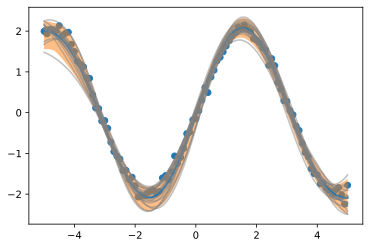

In [11]:
gpstate = randomize.apply(params,next(rng),gpstate)
plot(x[:,0],y[0,:],model.apply(params,jr.PRNGKey(0),x,gpstate)[:,0,:])